In [1]:
%matplotlib inline
import torch
import torchvision
import pandas as pd
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from IPython import display
import trueskill
import random
import time
import math

/userhome/cs/chan0305/ENTER/envs/walkability/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [3]:
def read_judgements(path=None):
    records=[]
    if path is not None:
        full_path= path
    else:
        full_path="all_judgements.txt"
    with open(full_path) as f:
        for l in f.readlines():
            left, right, choice=l[:-1].split(",")
            left=left.split("/")[-1]
            right=right.split("/")[-1]
            rec=[left, right, choice]
            records.append(rec)
    return records[1:]


In [4]:
def create_tables(path=None):
    records=read_judgements(path)
    recordsDF=pd.DataFrame(records, columns=["left", "right", "choice"])
    images=list(recordsDF["left"].unique())+list(recordsDF["right"].unique())
    images=set(images)
    images=pd.DataFrame(images,columns=["Name"])
    images["mu"]=25
    images["sigma"]=25/3
    return records, images

In [5]:
def trueskill_run(records, images, epochs=10, plt_fig=True, selected=50, num_row=5, num_col=2):
    env=trueskill.TrueSkill(draw_probability=0)
    name=images.Name.tolist()
    random.shuffle(name)
    imgs_plot=name[:selected]
    plot_records={}
    assert num_row*num_col==epochs
    fig, ax =plt.subplots(num_row, num_col, figsize=(10, 25))
    name_to_idx={}
    for i, n in enumerate(images["Name"]):
        name_to_idx[n]=i
    for i in range(epochs):
        random.shuffle(records)
        images[f"mu_{i}"]=25
        images[f"sigma_{i}"]=25/3
        start=time.time()
        for rec in records:
            x=rec[0]
            y=rec[1]
            choice=int(rec[2])
            row_x=name_to_idx[x]
            row_y=name_to_idx[y]
            mu_x=images.iloc[row_x][f"mu_{i}"].item()
            mu_y=images.iloc[row_y][f"mu_{i}"].item()
            sigma_x=images.iloc[row_x][f"sigma_{i}"].item()
            sigma_y=images.iloc[row_y][f"sigma_{i}"].item()
            # print(mu_x,mu_y,sigma_x,sigma_y)
            Rx=trueskill.Rating(mu_x,sigma_x)
            Ry=trueskill.Rating(mu_y,sigma_y)
            if choice==0:
                result=trueskill.rate_1vs1(Rx,Ry,env=env)
                mu_x=result[0].mu
                mu_y=result[1].mu
                sigma_x=result[0].sigma
                sigma_y=result[1].sigma
            else:
                result=trueskill.rate_1vs1(Ry,Rx,env=env)
                mu_x=result[1].mu
                mu_y=result[0].mu
                sigma_x=result[1].sigma
                sigma_y=result[0].sigma
                
            images.at[row_x , f"mu_{i}"]=mu_x
            images.at[row_x , f"sigma_{i}"]=sigma_x
            images.at[row_y , f"mu_{i}"]=mu_y
            images.at[row_y , f"sigma_{i}"]=sigma_y
            if x in imgs_plot:
                rank=mu_x-3*sigma_x
                try:
                    plot_records[x].append(rank)
                except:
                    plot_records[x]=[rank]

            if y in imgs_plot:
                rank=mu_y-3*sigma_y
                try:
                     plot_records[y].append(rank)
                except:
                     plot_records[y]=[rank]
                    
        axe=ax[i%num_row][i//num_row]
        for i2 , rec in plot_records.items():
            x=np.arange(len(rec))
            axe.plot(x, rec )   
        axe.set_title(f"plot of trueskil change_{i}")
        plot_records={}
        
        k=3
        images[f"rank_{i}"]=images[f"mu_{i}"]-k*images[f"sigma_{i}"]
        finish=time.time()
        print(f"round {i} finished, time:" , (finish-start)/60, "mins")
    return images

In [6]:
def init_pretrain(path=None, read=False, records_path=None, images_path=None):
    if read :
        # records=pd.readcsv(records_path)
        images=pd.read_csv(images_path)
        return images
    else:
        records, images= create_tables(path)
        images= trueskill_run(records, images)
        images.to_csv("trueskill_full.csv")   
        # records.to_csv("records.csv")
        return images

In [7]:
images=init_pretrain(read=True, images_path="trueskill_full.csv")
# images=init_pretrain()

In [8]:
def cal_Pwin(p1, p2, env=None):
#     return the probability of p1 win
    if env == None :
        env=trueskill.global_env()
    delta_mu= p1.mu- p2.mu
    sum_sigma= p1.sigma**2 + p2.sigma**2
    denominator= math.sqrt(2*(env.beta**2) + sum_sigma)
    return env.cdf(delta_mu / denominator)

def get2idx(num_images):
    idx1= random.randint(0,num_images-1)
    idx2= random.randint(0,num_images-1)
    return idx1, idx2

def getRecords(images, num_records=1000):
    num_images=len(images)
    col_to_check=[[],[]]
    newRecords=[]
    for i in range (10):
        col_to_check[0].append(f"mu_{i}")
        col_to_check[1].append(f"sigma_{i}")
    images["mu_mle"]= images[col_to_check[0]].mean(axis=1)
    images["sigma_mle"]= images[col_to_check[1]].mean(axis=1)*3030/3029
    for i in range(num_records):
        newR=[]
        idx1, idx2= get2idx(num_images)
        while idx1 ==idx2:
            idx1, idx2= get2idx(num_images)
        
        p1= images.iloc[idx1][["Name", "mu_mle", "sigma_mle"]]
        p2= images.iloc[idx2][["Name", "mu_mle", "sigma_mle"]]
        newR.append(p1.Name)
        newR.append(p2.Name)
        p1= trueskill.Rating(p1.mu_mle,p1.sigma_mle)
        p2= trueskill.Rating(p2.mu_mle,p2.sigma_mle)
        
        noise=torch.Tensor([0])
        noise=torch.nn.init.trunc_normal_(noise, a=-1, b=1).item()*0.05
        noise=abs(noise)
        p1_win=cal_Pwin(p1, p2)
        p1_win_=p1_win+(noise if p1_win+noise <1 else -noise)
        p2_win= 1- p1_win_
        if p1_win > 1 or p2_win >1 or p1_win <0 or p2_win <0:
            print(noise, p1_win,p1_win_, p2_win)
            break
        newR.append(p1_win)
        newR.append(p2_win)
        newRecords.append(newR)
        # break
    return newRecords        

In [9]:
def try_gpu():
    return torch.device("cuda:0")

In [10]:
def read_data(path, records):
    # path=path+("/train" if is_train==True else "/test")
    l=min(1000,len(records))
    img=[]
    labels=[]
    for R in records[:l]:
        image1= Image.open(os.path.join(path, R[0]))
        image2= Image.open(os.path.join(path, R[1]))
        img.append([image1, image2])
        labels.append(R[-2:])
        # labels.append((df.loc[df["Name"]==fname.lower(),"elo_reduced"].values[0]))
        
        # labels.append(int(df.loc[df["Name"]==fname.lower() , "cls"].values[0]))
        # break
    return img,labels

In [11]:
class StreetData_pretrain(torch.utils.data.Dataset):
    def __init__(self, path, records, device, is_train):
        self.path=path
        data, labels=read_data(path, records)
        if (is_train):
            self.transform=torchvision.transforms.Compose([
                # torchvision.transforms.ColorJitter(brightness=.5, hue=.3),
                # torchvision.transforms.RandomAffine(degrees=(-20,20),translate=(0.1,0.1),scale=((0.8,1.2)),shear=0.1),                              
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                # torchvision.transforms.RandomErasing(p=0.8 , scale=(0.1, 0.5))
                # torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
        else:
            self.transform=torchvision.transforms.Compose([
                torchvision.transforms.Resize(256),
                torchvision.transforms.CenterCrop(224),
                torchvision.transforms.ToTensor(),
                # torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        # print(data,device,labels)
        self.data=[]
        for imgs in data:
            img1=self.transform(imgs[0])
            img2=self.transform(imgs[1])
            img_tensor=torch.stack([img1,img2], dim=0)
            self.data.append(img_tensor)
        self.data=torch.stack(self.data, dim=0)
        self.labels=torch.Tensor(labels)
        
    def __getitem__(self, idx):
        return (self.data[idx], self.labels[idx])
    
    def __len__(self):
        return len(self.data)

In [12]:
def init_dataloader(path, images, train_ratio, test_ratio, val_ratio, batch_size=32, num_records=1000):
    if path is None:
        path= os.path.join(os.getcwd(), "dataset")
    newR= getRecords(images, num_records=num_records)
    lengthR=len(newR)
    device=try_gpu()
    random.shuffle(newR)
    assert train_ratio + test_ratio+ val_ratio == 1
    train_R= newR[:int(lengthR*train_ratio)]
    val_R= newR[int(lengthR*train_ratio):int(lengthR*(train_ratio+val_ratio))]
    test_R= newR[int(lengthR*(train_ratio+val_ratio)):]
    print("train: ", len(train_R), len(train_R)/len(newR))
    street_train= StreetData_pretrain(path, records=train_R, device=device, is_train=True)
    print("val: ", len(val_R), len(val_R)/len(newR))
    street_val= StreetData_pretrain(path, records=val_R, device=device, is_train=False)
    print("test: ", len(test_R), len(test_R)/len(newR))   
    street_test= StreetData_pretrain(path, records=test_R, device=device, is_train=False)
    
    train_iter= torch.utils.data.DataLoader(street_train, batch_size=batch_size, shuffle=True, drop_last=True)
    val_iter= torch.utils.data.DataLoader(street_val, batch_size=batch_size, shuffle=True, drop_last=False)
    test_iter= torch.utils.data.DataLoader(street_test, batch_size=batch_size, shuffle=True, drop_last=False)
    
    return train_iter, val_iter, test_iter

In [13]:
path= os.path.join(os.getcwd(), "dataset")
batch_size=16
train_iter, val_iter, test_iter= init_dataloader(path, images, train_ratio=0.75, val_ratio=0.2, test_ratio=0.05,
                                                 batch_size=batch_size,num_records=100000)

train:  75000 0.75
val:  20000 0.2
test:  5000 0.05


In [14]:
# a=torchvision.models.resnet152(pretrained=True)
# a=nn.Sequential(*list(a.children())[:-2])
# x=torch.randn((1,3,224,224))
# y=a(x)
# print(y.shape)

In [14]:
# --------------------------------------------------------
# Swin Transformer
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ze Liu
# --------------------------------------------------------

import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w] , indexing="ij"))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(x)

        # FFN
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


class SwinTransformer(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                 patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)  # B L C
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

In [40]:
swin=SwinTransformer()
x=torch.randn(1,3,224,224)
# y=swin.forward_features(x)
# print(y.shape)
a=swin.layers
x=swin.patch_embed(x)
print(x.shape)
for l in a:
    x=l(x)
    print(x.shape)
# x=torch.randn(1,3,224,224)
# y=a(x)
# print(y.shape)

torch.Size([1, 3136, 96])
torch.Size([1, 784, 192])
torch.Size([1, 196, 384])
torch.Size([1, 49, 768])
torch.Size([1, 49, 768])


In [63]:
swin=SwinTransformer()
swin.load_state_dict(torch.load("weight/swin_tiny_patch4_window7_224.pth")['model'])
# swin.patch_embed

<All keys matched successfully>

In [71]:
###### from torch.nn import functional as F
from torch import nn
class Residual(nn.Module):
    def __init__(self, in_chans, num_chans,kernel_size=3,padding=1, stride=1, use_1x1= False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_chans, num_chans, kernel_size=kernel_size, padding=padding, stride=stride)

        self.conv2 = nn.Conv2d(num_chans, num_chans, kernel_size=kernel_size-((kernel_size+1)%2), padding=padding)
        if use_1x1:
            self.conv3= nn.Conv2d(in_chans, num_chans, kernel_size,padding=padding, stride=stride)
        else:
            self.conv3= None
        self.bn1=nn.BatchNorm2d(num_chans)
        self.bn2=nn.BatchNorm2d(num_chans)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        # print(Y.shape, X.shape)
        Y += X
        return F.relu(Y)


def ResBlock(in_chans, num_chans, num_res, first_block=False):
    blk=[]
    for i in range(num_res):
        if i==0 and not first_block:
            blk.append(Residual(in_chans, num_chans, stride=2, use_1x1=True))
        elif i==0 and first_block:
            blk.append(Residual(in_chans, num_chans, kernel_size=4, padding=1, stride=2, use_1x1=True))
        else:
            blk.append(Residual(num_chans, num_chans))
        
    return blk

    
class olioli(nn.Module):
    def __init__(self ):
        super().__init__()
        # self.resnet=torchvision.models.resnet152(pretrained=True)
        # self.backbone=nn.Sequential(*list(self.resnet.children())[:-1], nn.Flatten()) #[1, 2048, 7, 7]
        self.swin=SwinTransformer()
        self.swin.load_state_dict(torch.load("weight/swin_tiny_patch4_window7_224.pth")['model'])
        self.norm=nn.LayerNorm(768)
        self.avgpool=nn.AdaptiveAvgPool1d(1)
        # self.backbone=self.swin.layers
        
        # self.flatten_layer=nn.Flatten(start_dim=-2) #[1, 2048, 49]
        
        # d1=nn.Sequential(*ResBlock(1, 2, 2, first_block=True)) # [1, 2, 24, 24]
#         d2=nn.Sequential(*ResBlock(2, 4, 2))# [1, 4, 12, 12]
#         d3=nn.Sequential(*ResBlock(4, 8, 2))# [1, 8, 6, 6]
#         self.decoder=nn.Sequential(d1, d2, d3,
#                                   nn.AdaptiveAvgPool2d((1,1)),
#                                   nn.Flatten(), nn.Linear(8, 2))
        # self.decoder=nn.Sequential(nn.Linear(4096, 1024), nn.Linear(1024, 256), nn.Linear(256,2))
        self.decoder=nn.Sequential(nn.Linear(1536, 1024), nn.Linear(1024, 256), nn.Linear(256,2))
    
        self.softmax=nn.Softmax(dim=-1)
    def swin_forward(self,x):
        x= self.swin.patch_embed(x)
        for layer in self.swin.layers:
            x=layer(x)
        x = self.norm(x)
        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x
            
    def forward(self, X):
        
        height=X.shape[-2]
        width=X.shape[-1]
        X=X.reshape(2, -1, 3, height, width)
        img1= X[0]
        img2= X[1]
        # print(img1.shape, img2.shape)
        # img1=self.backbone(img1)
        # img2=self.backbone(img2)
        img1=self.swin_forward(img1)
        img2=self.swin_forward(img2)
        
        # print(img1.shape, img2.shape)

        X=torch.cat((img1, img2), dim=-1)
        X=self.decoder(X)
        # img1=self.flatten_layer(self.backbone(img1))
        # img2=self.flatten_layer(self.backbone(img2))
        # img1_T=img1.reshape(-1, img1.shape[-1], img1.shape[-2])
        # # print(img1_T.shape, img2.shape)
        # interaction= torch.matmul(img1_T, img2) #[-1, 49, 49]
        # interaction=torch.unsqueeze(interaction, dim=1)
        # # print(interaction.shape)
        # X=self.decoder(interaction)
        # X=self.softmax(X)
        return X
        
        

In [65]:
net=olioli()
x=torch.randn(1,2,3,224,224)
y=net(x)
# print(y.shape)

torch.Size([1, 768]) torch.Size([1, 768])


In [66]:
def set_axes(axes, xlabel, ylabel, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    # axes.set_xlim(xlim)
    # axes.set_ylim(ylim)
    axes.legend(legend)
    axes.grid()
    return axes
def add(fig,axe,x,y,X,Y):
    n=len(y)
    x=[x]*n
    fmts=('b-', 'm-', 'b--', 'm--')
    for i,(a,b) in enumerate(zip(x,y)):
        X[i].append(a)
        Y[i].append(b)
    axe.cla()
    for (x,y,_) in zip(X,Y,fmts):
        axe.plot(x,y,_)
    axe=set_axes(axe,xlabel="epoch",ylabel=None ,xscale='linear', yscale='linear',legend=["train_loss","test_loss"])
    display.display(fig)
    display.clear_output(wait=True)
    return X,Y

In [67]:
def to_one_hot(y):
    one_hot=torch.zeros(size=(y.shape))
    winner=torch.argmax(y, dim = -1)
    one_hot[torch.arange(len(winner)), winner]=1
    return one_hot

In [68]:
def train(train_iter,test_iter,net,lr,num_epochs,save_name):
    device=try_gpu()
    # loss=nn.MSELoss()
    # loss=nn.L1Loss()
    loss=nn.CrossEntropyLoss()
    # trainer = torch.optim.SGD(params=net.parameters(),lr=lr,weight_decay=0.01)
    trainer=torch.optim.AdamW(params=net.parameters(),lr=lr)
    net=net.to(device)
    net.train()
    min_loss=999
    figsize=(10,10)
    fig,axe=plt.subplots(1,1,figsize=figsize)
    X_rec=[[],[]]
    Y_rec=[[],[]]
#     other network
    for epoch in range(num_epochs):
        train_l=[]
        for X,Y in train_iter:
            Y=to_one_hot(Y)
            X = X.to(device) 
            Y = Y.to(device)
            trainer.zero_grad()
            y_hat=net(X)
            l=loss(y_hat,Y)
            # print(y_hat, Y)
            # print(l)
            l.backward()
            trainer.step()
            train_l.append(l.item())
            # break
        # break
        if (epoch+1) %5 ==0 or epoch==0 or epoch==(num_epochs-1):
            train_l=np.array(train_l).mean()
            test_l=evaluate_accuracy(net, test_iter,device=device)
            print(f"Epoch {epoch+1} Train Loss : {train_l}, Test Loss : {test_l}")
#             print(epoch+1,[train_l,test_l])
            X_rec,Y_rec=add(fig,axe,epoch+1,[train_l,test_l],X_rec,Y_rec)
            
            # torch.save(net.state_dict(), f"weight/resnet_{epoch+1}.pt")
        if(test_l<min_loss):
            torch.save(net.state_dict(), f"weight/{save_name}_best.pt")
            min_loss=test_l
    print(f"Epoch Final Train Loss : {train_l}, Test Loss : {min_loss}")
    torch.save(net.state_dict(), f"weight/{save_name}_final.pt")

    
        

In [69]:
def evaluate_accuracy(net, data_iter, device=None,show_scatter=False ): 
    net=net.to(device)
    net.eval()
    # loss=nn.MSELoss()
    # loss=nn.L1Loss()
    loss=nn.CrossEntropyLoss()
    l_list=[]
    y_hat_list=[]
    y_list=[]
    with torch.no_grad():
        for X, y in data_iter:
            y=to_one_hot(y)
            X = X.to(device)
            y = y.to(device)
            y_hat=net(X)
            # y_hat=y_hat.reshape((batch_size,-1))
            l=loss(y_hat,y)
            l_list.append(l.item())
    #         for i in range(len(y)):
    #             y_hat_list.append(y_hat[i].item())
    #             y_list.append(y[i].item())
    # if show_scatter==True:
    #     plt.scatter(y_list,y_hat_list,s=0.5)
    l_list=np.array(l_list)
    return l_list.mean()

def evaluate_accuracy_with_plot(net, data_iter,title , device=None,show_scatter=False): 
#     regression
    net=net.to(device)
    net.eval()
    loss=nn.MSELoss()
    l_list=[]
    y_hat_list=[]
    y_list=[]
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat=net(X)
            # y_hat=y_hat.reshape((y.shape[0],-1))
            # l=loss(y_hat,y)
            # print(y_hat)
            l_list.append(l.item())
            for i in range(len(y)):
                y_hat_list.append(y_hat[i].item())
                y_list.append(y[i].item())
    if show_scatter==True:
        plt.scatter(y_list,y_hat_list,s=0.5)
        plt.title(title)
    l_list=np.array(l_list)
    print("Average Loss: " , l_list.mean())
    return 0
    
#    classification     
    # net=net.to(device)
    # net.eval()
    # loss=nn.CrossEntropyLoss()
    # l_list=[]
    # y_hat_list=[]
    # y_list=[]
    # acc=[]
    # with torch.no_grad():
    #     for X, y in data_iter:
    #         X = X.to(device)
    #         y = y.to(device)
    #         y_hat=net(X)
    #         y_hat=y_hat.reshape((y.shape[0],-1))
    #         pred_label=torch.argmax(y_hat , dim = 1).to("cpu")
    #         label=y.to("cpu")
    #         # label=torch.argmax(y , dim = 1).to("cpu")
    #         a= torch.sum(pred_label == label)/y.shape[0]
    #         acc.append(a)
    #         for i in range(len(y)):
    #             y_hat_list.append(pred_label[i])
    #             y_list.append(label[i])
    # count=np.array([y_list,y_hat_list])
    # count=np.transpose(count)
    # tup,counts=np.unique(count,axis=0,return_counts=1)
    # size=list(5*len(y_list)*counts/counts.sum())
    # d={tuple(i):j for i,j in zip(tup,size)}
    # size=[]
    # for i in count :
    #     size.append(d[tuple(i)])
    # if show_scatter==True:
    #     plt.scatter(y_list,y_hat_list,s=size)
    # acc=np.array(acc)
    # return acc.mean()

KeyboardInterrupt: 

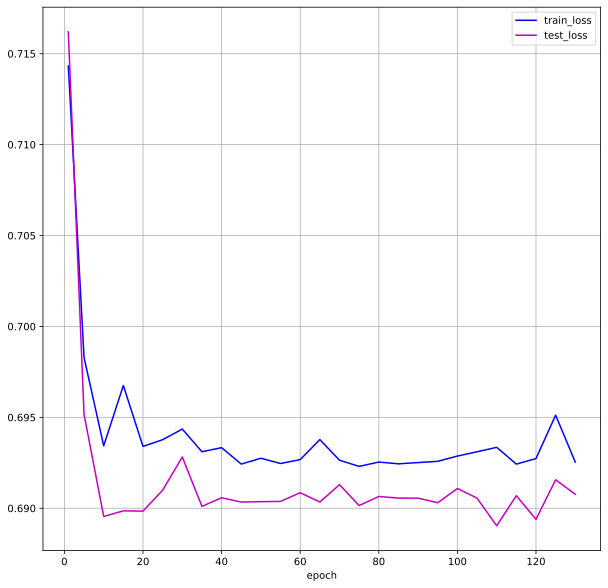

In [74]:
net=olioli()
train(train_iter,val_iter,net,1e-4,200, save_name="oli_swin_OH_CE_10k")

In [ ]:
net2=net
finetune=nn.Sequential(net2.resnet, nn.AdaptiveAvgPool2d(output_size=(1, 1)),
                      nn.Flatten(), nn.Linear(2048, 1024),nn.Linear(1024, 256), nn.Linear(256, 1))
print(finetune)